In [1]:
#! /usr/bin/env python3
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from statistics import mode
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

label_names =["hate", "offensive"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU:',torch.cuda.get_device_name(device=device))

def preprecess(dataset):
    processed_data = []
    for id, ann, rationale, tokens in zip(dataset['id'], dataset['annotators'], dataset['rationales'], dataset['post_tokens']):
        if rationale != []:
            if len(rationale) == 2:
                token_label = [1 if i > 1 else 0 for i in [rationale[0][j]+rationale[1][j] for j in range(len(rationale[0]))]]
            elif len(rationale) == 3:
                token_label = [1 if i > 1 else 0 for i in [rationale[0][j]+rationale[1][j]+rationale[2][j] for j in range(len(rationale[0]))]]
            else:
                raise ValueError("Rationale length is not 2 or 3")
            
            label = ann['label']
            gold_label = mode(label)
            text = ' '.join(tokens)

            processed_data.append({'id': id, 'label': gold_label, 'token_label': token_label, 'tokens': tokens, 'text': text})
        else:
            continue

    print(f"Number of processed data: {len(processed_data)}, Number of original data: {len(dataset)}")
    print(f"Example of processed data: {processed_data[0]}")
    return processed_data

# Loading data
train_df = preprecess(load_dataset('hatexplain', split='train'))
valid_df = preprecess(load_dataset('hatexplain', split='validation'))
test_df = preprecess(load_dataset('hatexplain', split='test'))

GPU: NVIDIA GeForce RTX 3090


Found cached dataset hatexplain (/home/hongbo/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


Number of processed data: 9132, Number of original data: 15383
Example of processed data: {'id': '23107796_gab', 'label': 2, 'token_label': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens': ['u', 'really', 'think', 'i', 'would', 'not', 'have', 'been', 'raped', 'by', 'feral', 'hindu', 'or', 'muslim', 'back', 'in', 'india', 'or', 'bangladesh', 'and', 'a', 'neo', 'nazi', 'would', 'rape', 'me', 'as', 'well', 'just', 'to', 'see', 'me', 'cry'], 'text': 'u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry'}


Found cached dataset hatexplain (/home/hongbo/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


Number of processed data: 1141, Number of original data: 1922
Example of processed data: {'id': '15473637_gab', 'label': 0, 'token_label': [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens': ['democrats', 'from', 'minnesota', 'leftist', 'muzzie', 'shithole', 'are', 'the', 'dumbest', 'anti', 'americans', 'there', 'are', 'klobuchar', 'one', 'of', 'the', 'reps', 'is', 'a', 'dumb', 'bitch', 'who', 'has', 'a', 'moronic', 'position', 'on', 'the', 'tax', 'bill', 'fuck', 'this', 'stupid', 'woman'], 'text': 'democrats from minnesota leftist muzzie shithole are the dumbest anti americans there are klobuchar one of the reps is a dumb bitch who has a moronic position on the tax bill fuck this stupid woman'}


Found cached dataset hatexplain (/home/hongbo/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


Number of processed data: 1142, Number of original data: 1924
Example of processed data: {'id': '1252707503441313794_twitter', 'label': 2, 'token_label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'tokens': ['<user>', '<user>', 'why', 'are', 'you', 'repeating', 'yourself', 'are', 'you', 'a', 'little', 'retarded'], 'text': '<user> <user> why are you repeating yourself are you a little retarded'}


In [2]:
train_texts, train_labels = [], []
for i in train_df:
    train_texts.append(i['text'])
    train_labels.append(i['label'])

valid_texts, valid_labels = [], []
for i in valid_df:
    valid_texts.append(i['text'])
    valid_labels.append(i['label'])

train_labels = [1 if x == 2 else x for x in train_labels]
valid_labels = [1 if x == 2 else x for x in valid_labels]

train_labels_set = set(train_labels)
print(f"train_labels_set:{train_labels_set}")
valid_labels_set = set(valid_labels)
print(f"valid_labels_set:{valid_labels_set}")

train_labels_set:{0, 1}
valid_labels_set:{0, 1}


In [3]:
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case = True)

def encode(docs):
    encoded_dict = tokenizer(docs, add_special_tokens=True, max_length=128, padding=True, return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [4]:
train_input_ids, train_att_masks = encode(train_texts)
valid_input_ids, valid_att_masks = encode(valid_texts)

train_y = torch.tensor(train_labels)
valid_y = torch.tensor(valid_labels)

In [5]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 128 # 128 for 3090

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [6]:
N_labels = 2

model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import torch, os, shutil
import math

EPOCHS = 50
LEARNING_RATE = 5e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*EPOCHS )

train_loss_per_epoch = []
val_loss_per_epoch = []
valid_acc = []

PATH = '/mnt/b432dc15-0b9a-4f76-9076-5bf99fe91d74/Hongbo/LIPEx/code_Text/hateSpeech'
best_model_path = os.path.join(PATH, 'best_ckpt')
_acc = float('-inf')
patience = 0

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0 
 
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            step_output = output.logits
            step_output = torch.softmax(step_output, dim=1).detach().cpu().numpy()
            step_output = np.argmax(step_output, axis=1).flatten()
            step_label_ids = labels.cpu().numpy().flatten()
            if step_num_e == 0:
                y_pred = step_output
                y_true = step_label_ids
            else:
                y_pred = np.concatenate((y_pred, step_output))
                y_true = np.concatenate((y_true, step_label_ids))
        
        accuracy = (y_true == y_pred).sum() / len(y_true)
        valid_acc.append(accuracy)
        print("Validation Accuracy: {}".format(accuracy))
        if accuracy > _acc:
            patience = 0
            _acc = accuracy
            if os.path.exists(best_model_path):
                shutil.rmtree(best_model_path)
                os.makedirs(best_model_path)
            else:
                os.makedirs(best_model_path)
            torch.save(model.state_dict(), os.path.join(best_model_path, 'model-'+str(epoch_num+1)+'.pt'))
        else:
            patience += 1
            if patience > 10: # if accuracy does not improve for 10 epochs, then we stop training
                break

    valid_loss = (valid_loss / (step_num_e + 1))
    val_loss_per_epoch.append(valid_loss)
        
    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s]


Validation Accuracy: 0.8028045574057844
72/72 train loss: 0.5123165961768892 
9/9 val loss: 0.04955406542177553 
Epoch:  2


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.48it/s]


Validation Accuracy: 0.8177037686240141
72/72 train loss: 0.3982967287302017 
9/9 val loss: 0.04948931490933453 
Epoch:  3


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


Validation Accuracy: 0.7519719544259421
72/72 train loss: 0.28904101645780933 
9/9 val loss: 0.06776230791468679 
Epoch:  4


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s]


Validation Accuracy: 0.7922874671340929
72/72 train loss: 0.18556912201974127 
9/9 val loss: 0.07385239924913571 
Epoch:  5


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s]


Validation Accuracy: 0.7808939526730938
72/72 train loss: 0.11478279888009031 
9/9 val loss: 0.09067198450182691 
Epoch:  6


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s]


Validation Accuracy: 0.782646801051709
72/72 train loss: 0.06776695034932345 
9/9 val loss: 0.10741437953195454 
Epoch:  7


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s]


Validation Accuracy: 0.7852760736196319
72/72 train loss: 0.05735133807562912 
9/9 val loss: 0.11126066210829182 
Epoch:  8


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


Validation Accuracy: 0.7712532865907099
72/72 train loss: 0.038817081092727475 
9/9 val loss: 0.12893521197048236 
Epoch:  9


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s]


Validation Accuracy: 0.7668711656441718
72/72 train loss: 0.02911406678483925 
9/9 val loss: 0.14396596396410907 
Epoch:  10


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s]


Validation Accuracy: 0.7852760736196319
72/72 train loss: 0.029057518868487224 
9/9 val loss: 0.1330586443712682 
Epoch:  11


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


Validation Accuracy: 0.775635407537248
72/72 train loss: 0.029421202789914485 
9/9 val loss: 0.14422310723198783 
Epoch:  12


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s]


Validation Accuracy: 0.7931638913234005
72/72 train loss: 0.019776629167608917 
9/9 val loss: 0.14296530058354506 
Epoch:  13


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.24it/s]

Validation Accuracy: 0.7975460122699386


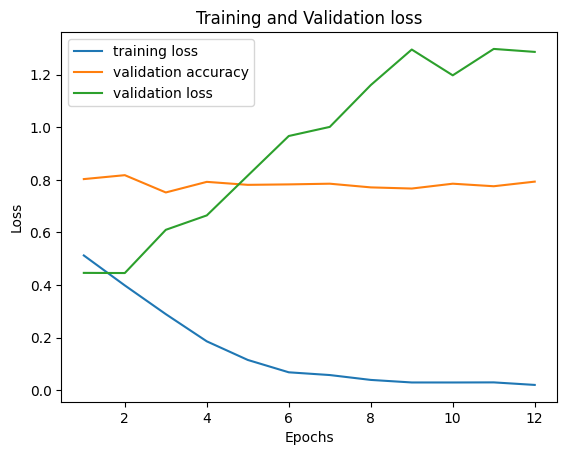

In [11]:
# draw the loss curve
epochs = range(1, epoch_num +1 )
fig, ax = plt.subplots()
ax.plot(epochs, train_loss_per_epoch[:-1], label ='training loss')
ax.plot(epochs, valid_acc[:-1], label = 'validation accuracy' )
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()